<a href="https://colab.research.google.com/github/omareldalil4/Assignment-3-CNN-LSTM-/blob/main/CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy pandas matplotlib seaborn scikit-learn tensorflow

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import urllib.request
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
def download_and_extract_uci_har_dataset():
    """
    Download and extract the UCI HAR dataset
    """
    data_dir = 'UCI HAR Dataset'

    if os.path.exists(data_dir):
        print(f"Dataset already exists in {data_dir}")
        return

    try:
        dataset_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip'
        zip_path = 'UCI_HAR_Dataset.zip'

        print("Downloading UCI HAR dataset...")
        urllib.request.urlretrieve(dataset_url, zip_path)

        print("Extracting dataset...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall('.')

        print(f"Dataset downloaded and extracted successfully to {data_dir}")

        os.remove(zip_path)
    except Exception as e:
        print(f"Error downloading or extracting dataset: {e}")
        raise


In [5]:
def load_uci_har_dataset(base_path='UCI HAR Dataset/'):
    """
    Load the UCI HAR dataset from the specified path.

    This function assumes the UCI HAR dataset is organized in the standard structure:
    - train/X_train.txt: Training set features
    - train/y_train.txt: Training set labels
    - test/X_test.txt: Test set features
    - test/y_test.txt: Test set labels
    - features.txt: List of all features
    - activity_labels.txt: Links the class labels with their activity name

    Returns:
    - X_train, X_test: Training and test features
    - y_train, y_test: Training and test labels
    - features: Names of the features
    - activities: Names of the activities
    """

    features = pd.read_csv(
        f'{base_path}features.txt',
        sep='\s+',
        header=None,
        names=['id', 'name']
    )


    feature_names = features['name'].values
    duplicate_count = {}
    unique_feature_names = []


    for name in feature_names:
        if name in duplicate_count:
            duplicate_count[name] += 1
            unique_feature_names.append(f"{name}_{duplicate_count[name]}")
        else:
            duplicate_count[name] = 0
            unique_feature_names.append(name)


    activities = pd.read_csv(
        f'{base_path}activity_labels.txt',
        sep='\s+',
        header=None,
        names=['id', 'name']
    )


    X_train = pd.read_csv(
        f'{base_path}train/X_train.txt',
        sep='\s+',
        header=None,
        names=unique_feature_names
    )
    y_train = pd.read_csv(
        f'{base_path}train/y_train.txt',
        sep='\s+',
        header=None,
        names=['activity']
    )


    X_test = pd.read_csv(
        f'{base_path}test/X_test.txt',
        sep='\s+',
        header=None,
        names=unique_feature_names
    )
    y_test = pd.read_csv(
        f'{base_path}test/y_test.txt',
        sep='\s+',
        header=None,
        names=['activity']
    )

    return X_train, y_train, X_test, y_test, unique_feature_names, activities


In [6]:
def preprocess_data(X_train, y_train, X_test, y_test, window_size=128, step=64):
    """
    Preprocess the data by standardizing features and reshaping for CNN-LSTM input.

    Args:
        X_train, X_test: Training and test feature DataFrames
        y_train, y_test: Training and test label DataFrames
        window_size: Size of the sliding window for segmentation
        step: Step size for the sliding window

    Returns:
        X_train_reshaped, X_test_reshaped: Reshaped feature arrays for CNN-LSTM
        y_train_cat, y_test_cat: One-hot encoded labels
    """

    X_train_np = X_train.values
    X_test_np = X_test.values
    y_train_np = y_train.values.ravel()
    y_test_np = y_test.values.ravel()


    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_np)
    X_test_scaled = scaler.transform(X_test_np)


    y_train_enc = y_train_np - 1
    y_test_enc = y_test_np - 1


    num_classes = len(np.unique(y_train_enc))
    y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
    y_test_cat = to_categorical(y_test_enc, num_classes=num_classes)


    def create_windows(data, labels, window_size, step):
        windows = []
        window_labels = []

        for i in range(0, len(data) - window_size + 1, step):
            window = data[i:i + window_size]

            label = labels[i + window_size - 1]

            windows.append(window)
            window_labels.append(label)

        return np.array(windows), np.array(window_labels)


    X_train_windows, y_train_windows = create_windows(
        X_train_scaled, y_train_cat, window_size, step
    )


    X_test_windows, y_test_windows = create_windows(
        X_test_scaled, y_test_cat, window_size, step
    )


    num_features = X_train_scaled.shape[1]
    X_train_reshaped = X_train_windows.reshape(-1, window_size, num_features)
    X_test_reshaped = X_test_windows.reshape(-1, window_size, num_features)

    return X_train_reshaped, y_train_windows, X_test_reshaped, y_test_windows


In [7]:
def build_cnn_lstm_model(input_shape, num_classes):
    """
    Build a CNN-LSTM model for HAR.

    Args:
        input_shape: Shape of input data (time_steps, features)
        num_classes: Number of activity classes

    Returns:
        model: Compiled CNN-LSTM model
    """
    model = Sequential()

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Dropout(0.2))

    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Dropout(0.2))

    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(64))
    model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['acc']
    )

    return model

In [8]:
def train_model(model, X_train, y_train, X_val, y_val, batch_size=32, epochs=50):
    """
    Train the CNN-LSTM model with callbacks for early stopping and learning rate reduction.

    Args:
        model: The compiled CNN-LSTM model
        X_train, y_train: Training data and labels
        X_val, y_val: Validation data and labels
        batch_size: Batch size for training
        epochs: Maximum number of epochs

    Returns:
        history: Training history
        model: Trained model
    """

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    lr_reducer = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    model_checkpoint = ModelCheckpoint(
        'best_cnn_lstm_model.h5',
        monitor='val_acc',
        save_best_only=True,
        verbose=1
    )

    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, lr_reducer, model_checkpoint],
        verbose=1
    )

    return history, model


In [9]:
def evaluate_model(model, X_test, y_test, activity_names, training_history):
    """
    Evaluate the trained model on the test set and visualize results.

    Args:
        model: Trained CNN-LSTM model
        X_test, y_test: Test data and labels
        activity_names: Names of the activities for labeling
        training_history: Training history object returned from model.fit()

    Returns:
        test_accuracy: Accuracy on the test set
    """
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_test, axis=1)

    test_accuracy = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print("\nClassification Report:")
    class_report = classification_report(
        y_true, y_pred,
        target_names=activity_names,
        digits=4
    )
    print(class_report)

    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=activity_names,
        yticklabels=activity_names
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('har_confusion_matrix.png')
    plt.show()

    if training_history is not None and hasattr(training_history, 'history'):

        history = training_history.history

        if history and len(history) > 0:
            plt.figure(figsize=(12, 4))

            print(f"Training History Keys: {list(history.keys())}")

            if 'acc' in history and 'val_acc' in history:
                plt.subplot(1, 2, 1)
                plt.plot(history['acc'], label='Training')
                plt.plot(history['val_acc'], label='Validation')
                plt.title('Model Accuracy')
                plt.xlabel('Epoch')
                plt.ylabel('Accuracy')
                plt.legend()
            elif 'accuracy' in history and 'val_accuracy' in history:
                plt.subplot(1, 2, 1)
                plt.plot(history['accuracy'], label='Training')
                plt.plot(history['val_accuracy'], label='Validation')
                plt.title('Model Accuracy')
                plt.xlabel('Epoch')
                plt.ylabel('Accuracy')
                plt.legend()

            if 'loss' in history and 'val_loss' in history:
                plt.subplot(1, 2, 2)
                plt.plot(history['loss'], label='Training')
                plt.plot(history['val_loss'], label='Validation')
                plt.title('Model Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.legend()

            plt.tight_layout()
            plt.savefig('har_training_history.png')
            plt.show()
        else:
            print("Training history is empty. Cannot plot training curves.")
    else:
        print("No valid training history provided. Cannot plot training curves.")

    return test_accuracy


In [10]:
def visualize_sample_data(X_train, y_train, activities):
    """
    Visualize a sample of the data to help understand the features.

    Args:
        X_train: Training data
        y_train: Training labels
        activities: Activity names
    """

    activity_dict = dict(zip(activities['id'], activities['name']))
    y_train_with_names = y_train.copy()
    y_train_with_names['activity_name'] = y_train_with_names['activity'].map(activity_dict)


    train_data = pd.concat([X_train, y_train_with_names], axis=1)


    acc_columns = []
    for axis in ['X', 'Y', 'Z']:

        matching_cols = [col for col in X_train.columns if 'tBodyAcc-mean' in col and axis in col]
        if matching_cols:
            acc_columns.append(matching_cols[0])


    if len(acc_columns) < 3:
        acc_columns = [col for col in X_train.columns if 'tBodyAcc' in col][:3]


    activities_to_visualize = activities['name'].iloc[:3].values
    samples_per_activity = 100

    plt.figure(figsize=(15, 12))

    for i, activity in enumerate(activities_to_visualize):
        activity_data = train_data[train_data['activity_name'] == activity].iloc[:samples_per_activity]

        for j, col in enumerate(acc_columns[:3]):
            plt.subplot(3, 3, i*3 + j + 1)
            plt.plot(activity_data[col].values)
            plt.title(f'{activity} - {col}')
            plt.xlabel('Time step')
            plt.ylabel('Acceleration')

    plt.tight_layout()
    plt.savefig('har_accelerometer_samples.png')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.countplot(x='activity_name', data=train_data)
    plt.title('Activity Distribution in Training Set')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('har_activity_distribution.png')
    plt.show()

Starting CNN-LSTM Human Activity Recognition (HAR) model...
Extracting dataset...
Dataset downloaded and extracted successfully to UCI HAR Dataset
Loading UCI HAR dataset...
Dataset loaded successfully.
Training set shape: (7352, 561)
Test set shape: (2947, 561)
Activities: ['WALKING' 'WALKING_UPSTAIRS' 'WALKING_DOWNSTAIRS' 'SITTING' 'STANDING'
 'LAYING']
Visualizing sample data...


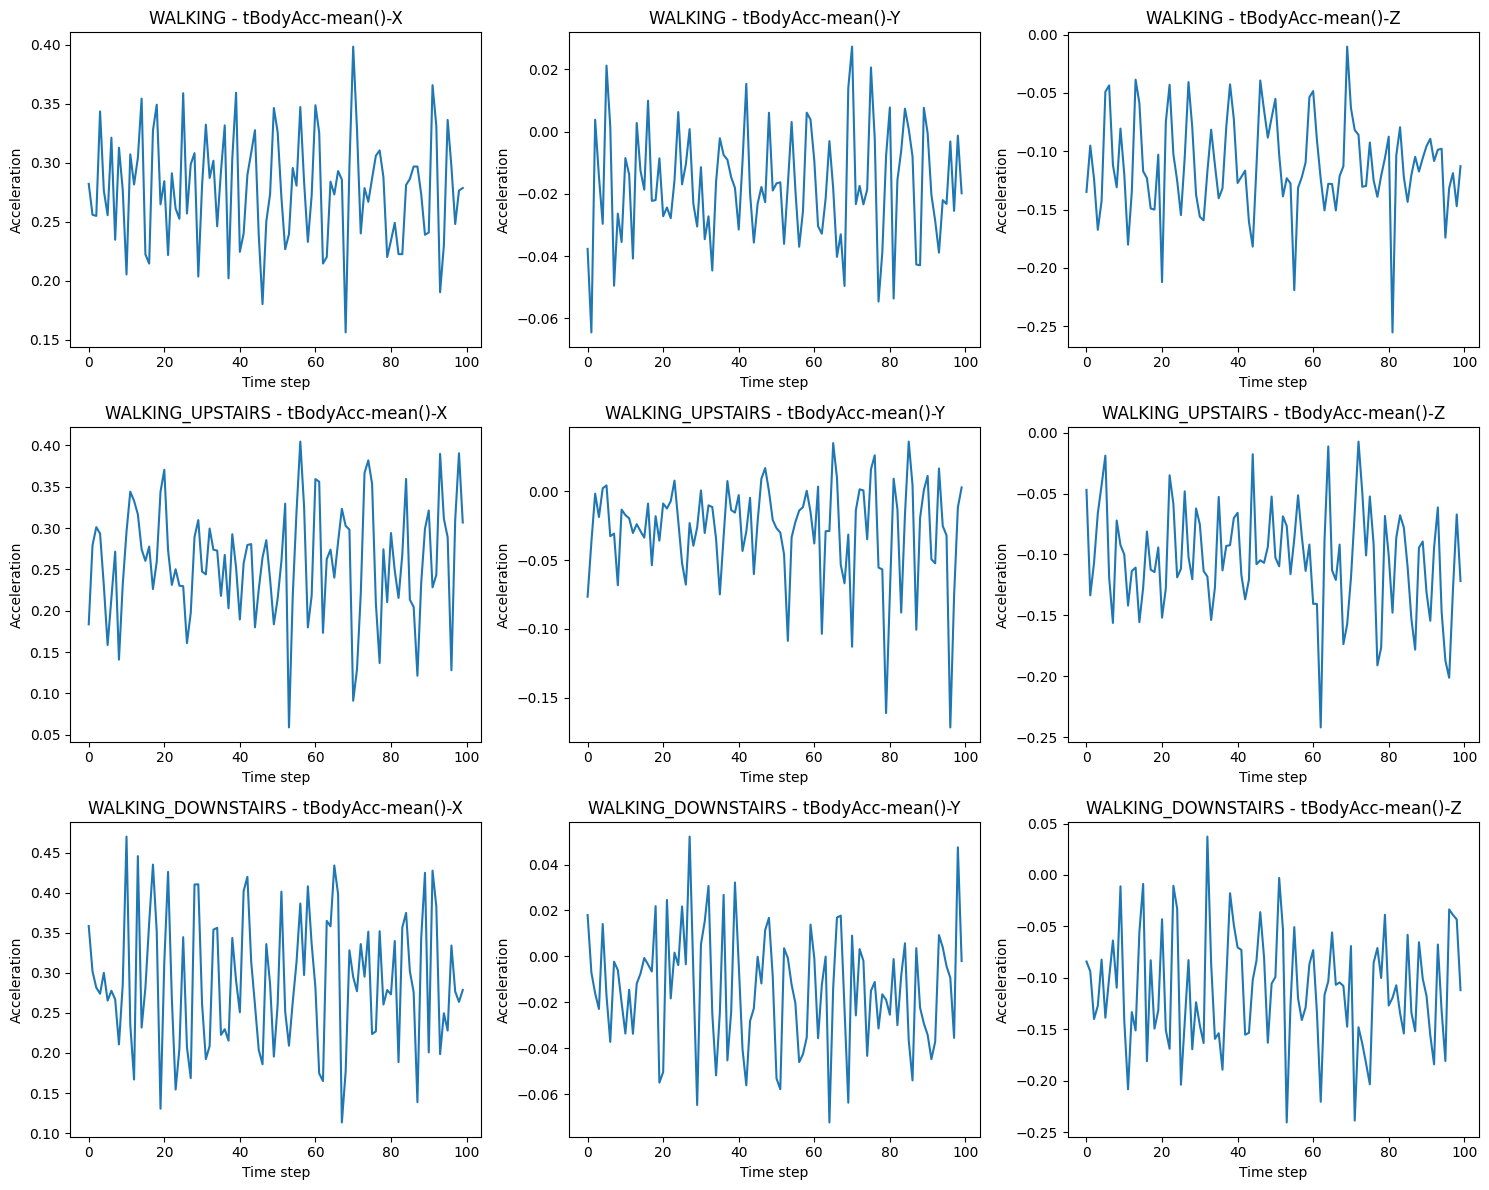

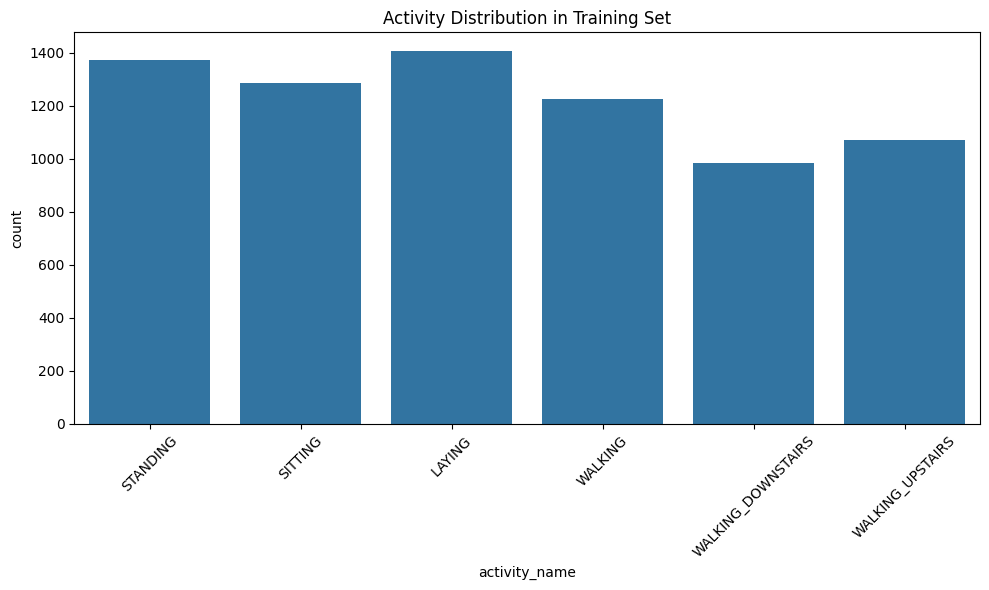

Preprocessing data...
Reshaped training data: (113, 128, 561)
Reshaped test data: (45, 128, 561)
Building CNN-LSTM model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 126, 64)             │         107,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 124, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 124, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 62, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 62, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 60, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 60, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 58, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 58, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 29, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 29, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 29, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 29, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │              

 Total params: 381,446 (1.46 MB)

 Trainable params: 380,550 (1.45 MB)

 Non-trainable params: 896 (3.50 KB)

Training model...
Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - acc: 0.1976 - loss: 2.4473
Epoch 1: val_acc improved from -inf to 0.21739, saving model to best_cnn_lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 744ms/step - acc: 0.2065 - loss: 2.4065 - val_acc: 0.2174 - val_loss: 1.7423 - learning_rate: 0.0010
Epoch 2/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - acc: 0.3750 - loss: 1.8787
Epoch 2: val_acc did not improve from 0.21739
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - acc: 0.4159 - loss: 1.7536 - val_acc: 0.2174 - val_loss: 1.7678 - learning_rate: 0.0010
Epoch 3/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - acc: 0.4375 - loss: 1.3386
Epoch 3: val_acc did not improve from 0.21739
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - acc: 0.5049 - loss: 1.2404 - val_acc: 0.2174 - val_loss: 1.6961 - learning_rate: 0.0010
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - acc: 0.5557 - loss: 0.9969
Epoch 4: val_acc improved from 0.21739 to 0.39130, saving model to best_cnn_lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - acc: 0.5640 - loss: 0.9707 - val_acc: 0.3913 - val_loss: 1.6010 - learning_rate: 0.0010
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - acc: 0.7095 - loss: 0.7062
Epoch 5: val_acc improved from 0.39130 to 0.52174, saving model to best_cnn_lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - acc: 0.7127 - loss: 0.6935 - val_acc: 0.5217 - val_loss: 1.5300 - learning_rate: 0.0010
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - acc: 0.7355 - loss: 0.7114 
Epoch 6: val_acc did not improve from 0.52174
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - acc: 0.7322 - loss: 0.7028 - val_acc: 0.5217 - val_loss: 1.4889 - learning_rate: 0.0010
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - acc: 0.7697 - loss: 0.6968 
Epoch 7: val_acc did not improve from 0.52174
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - acc: 0.7717 - loss: 0.6884 - val_acc: 0.5217 - val_loss: 1.4752 - learning_rate: 0.0010
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - acc: 0.6693 - loss: 0.7104
Epoch 8: val_acc did not improve from 0.52174
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - acc: 0.6798 - loss: 0.6965 - val_acc: 0.3913 - val_loss: 1.4935 - learning_rate: 0.0010
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - acc: 0.8336 - loss: 0.4328 
Epoch 9: val_acc did not improve f

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - acc: 0.9488 - loss: 0.2205 - val_acc: 0.6087 - val_loss: 1.2512 - learning_rate: 0.0010
Epoch 17/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - acc: 0.9688 - loss: 0.1878
Epoch 17: val_acc did not improve from 0.60870
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - acc: 0.9488 - loss: 0.2095 - val_acc: 0.6087 - val_loss: 1.2394 - learning_rate: 0.0010
Epoch 18/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - acc: 0.9688 - loss: 0.2284
Epoch 18: val_acc did not improve from 0.60870
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - acc: 0.9488 - loss: 0.2110 - val_acc: 0.5652 - val_loss: 1.2482 - learning_rate: 0.0010
Epoch 19/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - acc: 1.0000 - loss: 0.1410
Epoch 19: val_acc did not improve from 0.60870
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - acc: 0.9889 - loss: 0.1182 - val_acc: 0.6087 - val_loss: 1.2267 - learning_rate: 0.0010
Epoch 20/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - acc: 0.9688 - loss: 0.1417
Epoch 20: val_acc did not impr

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - acc: 0.9638 - loss: 0.1258 - val_acc: 0.7391 - val_loss: 1.0834 - learning_rate: 0.0010
Epoch 22/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - acc: 1.0000 - loss: 0.0828
Epoch 22: val_acc improved from 0.73913 to 0.78261, saving model to best_cnn_lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - acc: 0.9622 - loss: 0.1311 - val_acc: 0.7826 - val_loss: 1.0417 - learning_rate: 0.0010
Epoch 23/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - acc: 1.0000 - loss: 0.0808
Epoch 23: val_acc did not improve from 0.78261
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - acc: 0.9905 - loss: 0.0776 - val_acc: 0.7826 - val_loss: 0.9970 - learning_rate: 0.0010
Epoch 24/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - acc: 0.9375 - loss: 0.1439
Epoch 24: val_acc improved from 0.78261 to 0.82609, saving model to best_cnn_lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - acc: 0.9560 - loss: 0.1218 - val_acc: 0.8261 - val_loss: 0.9436 - learning_rate: 0.0010
Epoch 25/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - acc: 1.0000 - loss: 0.0589
Epoch 25: val_acc did not improve from 0.82609
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - acc: 0.9716 - loss: 0.1123 - val_acc: 0.8261 - val_loss: 0.8984 - learning_rate: 0.0010
Epoch 26/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - acc: 0.9688 - loss: 0.1257
Epoch 26: val_acc did not improve from 0.82609
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - acc: 0.9733 - loss: 0.0957 - val_acc: 0.7826 - val_loss: 0.8702 - learning_rate: 0.0010
Epoch 27/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - acc: 1.0000 - loss: 0.0563
Epoch 27: val_acc did not improve from 0.82609
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - acc: 0.9944 - loss: 0.0557 - val_acc: 0.7826 - val_loss: 0.8532 - learning_rate: 0.0010
Epoch 28/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - acc: 1.0000 - loss: 0.0782
Epoch 28: val_acc did not imp

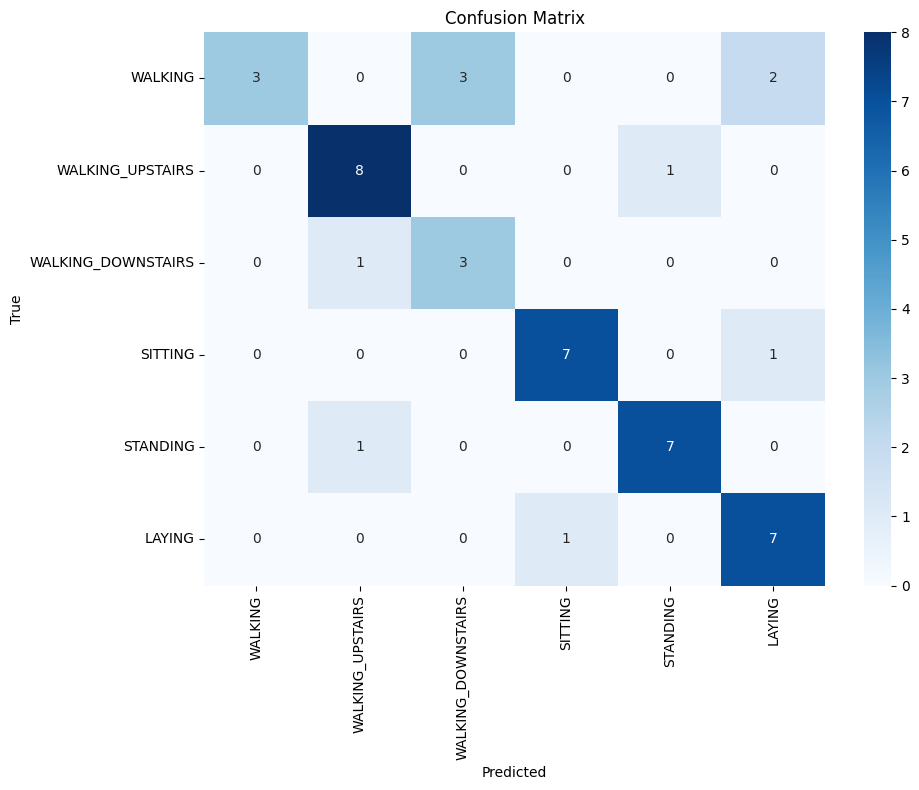

Training History Keys: ['acc', 'loss', 'val_acc', 'val_loss', 'learning_rate']


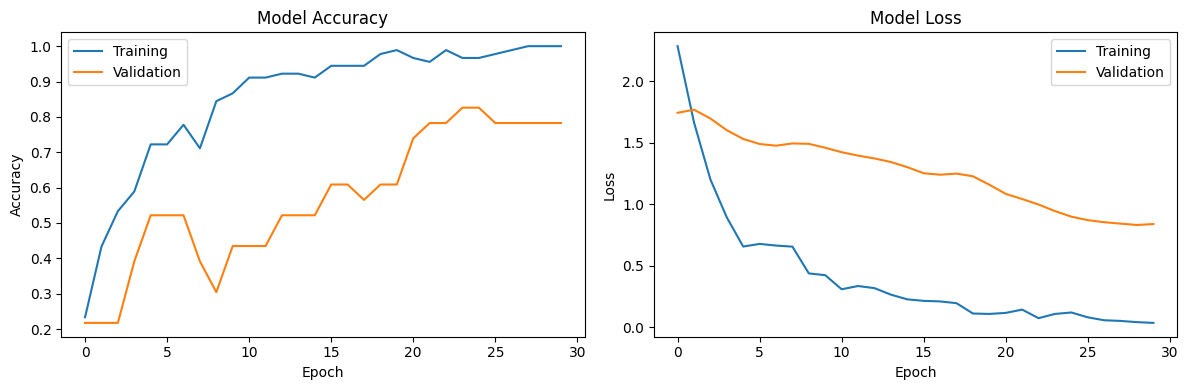

Final test accuracy: 0.7778
HAR CNN-LSTM pipeline completed successfully.


In [11]:
def main():
    """
    Main function to run the HAR pipeline
    """

    download_and_extract_uci_har_dataset()

    print("Loading UCI HAR dataset...")

    try:
        X_train, y_train, X_test, y_test, feature_names, activities = load_uci_har_dataset()

        print("Dataset loaded successfully.")
        print(f"Training set shape: {X_train.shape}")
        print(f"Test set shape: {X_test.shape}")


        activity_names = activities['name'].values
        print(f"Activities: {activity_names}")


        print("Visualizing sample data...")
        visualize_sample_data(X_train, y_train, activities)


        print("Preprocessing data...")
        X_train_reshaped, y_train_cat, X_test_reshaped, y_test_cat = preprocess_data(
            X_train, y_train, X_test, y_test
        )

        print(f"Reshaped training data: {X_train_reshaped.shape}")
        print(f"Reshaped test data: {X_test_reshaped.shape}")


        X_train_final, X_val, y_train_final, y_val = train_test_split(
            X_train_reshaped, y_train_cat, test_size=0.2, random_state=42
        )


        print("Building CNN-LSTM model...")
        input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])
        num_classes = y_train_cat.shape[1]
        model = build_cnn_lstm_model(input_shape, num_classes)


        model.summary()


        print("Training model...")
        history, trained_model = train_model(
            model, X_train_final, y_train_final, X_val, y_val, epochs=30
        )


        print("Evaluating model...")
        test_accuracy = evaluate_model(
            trained_model, X_test_reshaped, y_test_cat, activity_names, history
        )

        print(f"Final test accuracy: {test_accuracy:.4f}")
        print("HAR CNN-LSTM pipeline completed successfully.")

    except Exception as e:
        print(f"Error in main function: {e}")
        import traceback
        traceback.print_exc()


if __name__ == "__main__":
    try:
        print("Starting CNN-LSTM Human Activity Recognition (HAR) model...")
        main()
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
